## Import Modules

In [38]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os, glob     # 운영체제와의 상호작용, 파일들의 리스트를 뽑을때 사용
from moviepy.editor import VideoFileClip    # 비디오 처리

# jupyter notebook에서 그래프 바로 볼 수 있게 해줌
%matplotlib inline
# 그래프를 더 높은 해상도로 출력
%config InlineBakend.figure_format = 'retina'

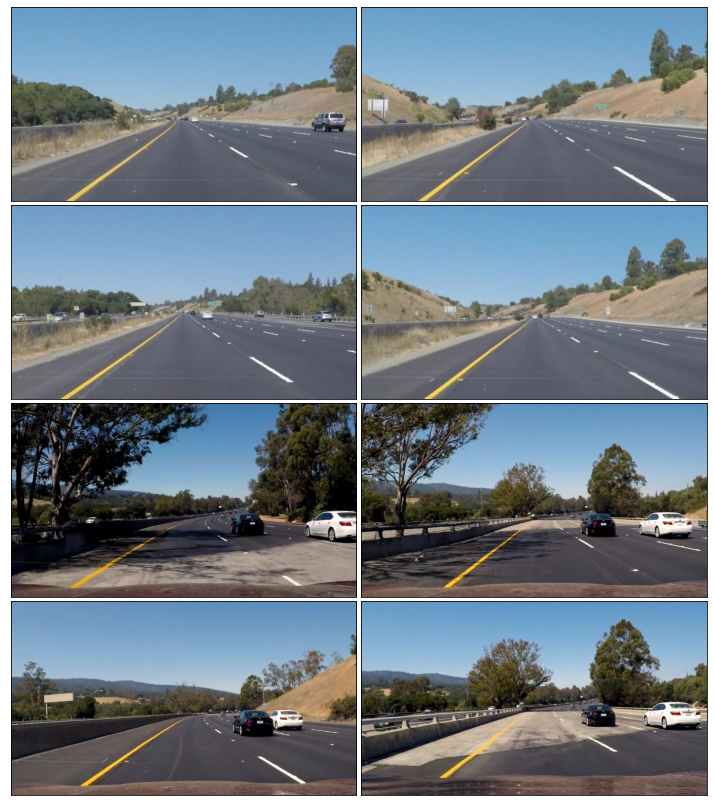

In [39]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

test_images = [plt.imread(path) for path in glob.glob('test_images_yellow/*.jpg')]
show_images(test_images)

## RGB Color Space

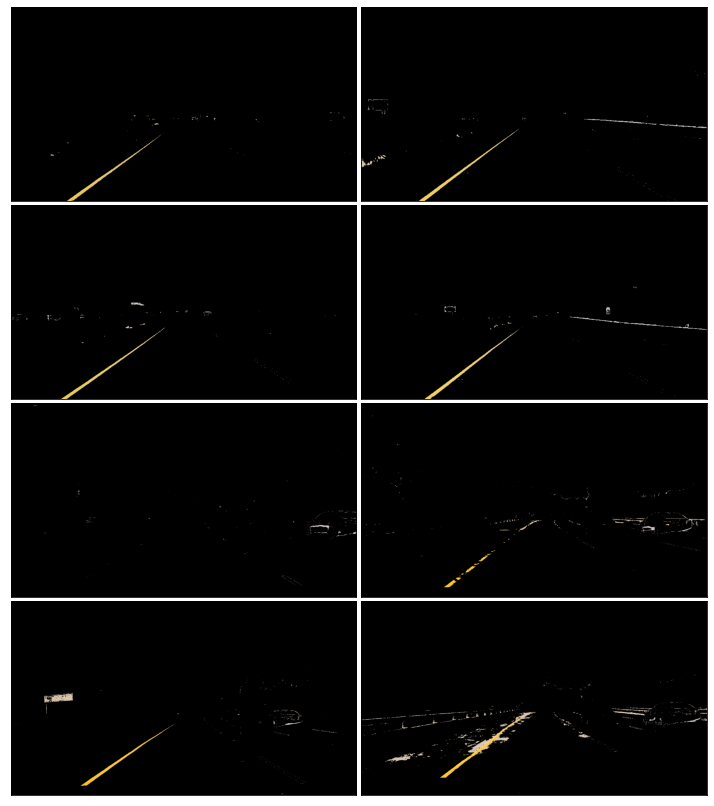

In [40]:
def select_rgb_yellow(image): 
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 200])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_and(image, image, mask = yellow_mask)
    return mask

show_images(list(map(select_rgb_yellow, test_images)))

## HSV Color Space

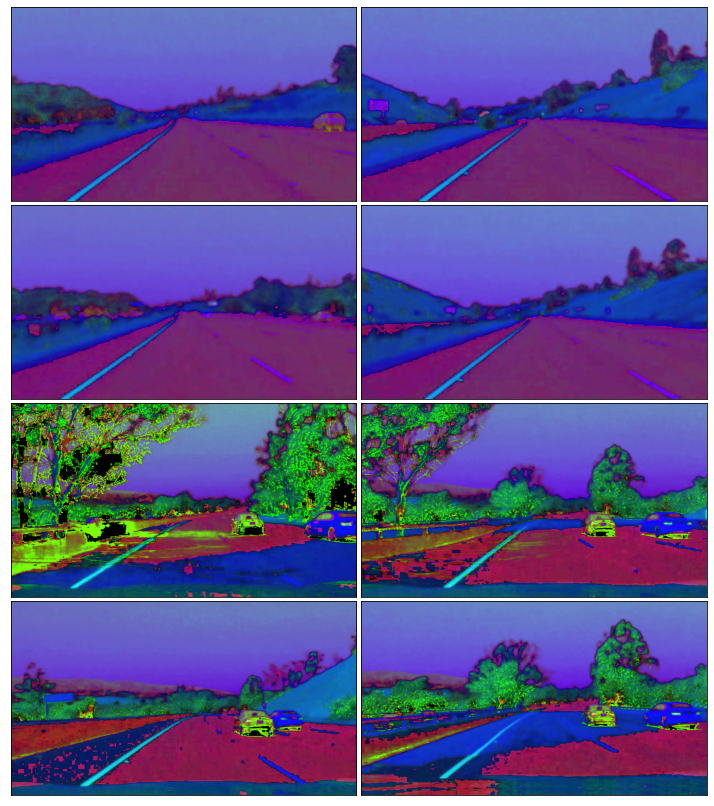

In [41]:
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

show_images(list(map(convert_hsv, test_images)))

## HLS Color Space

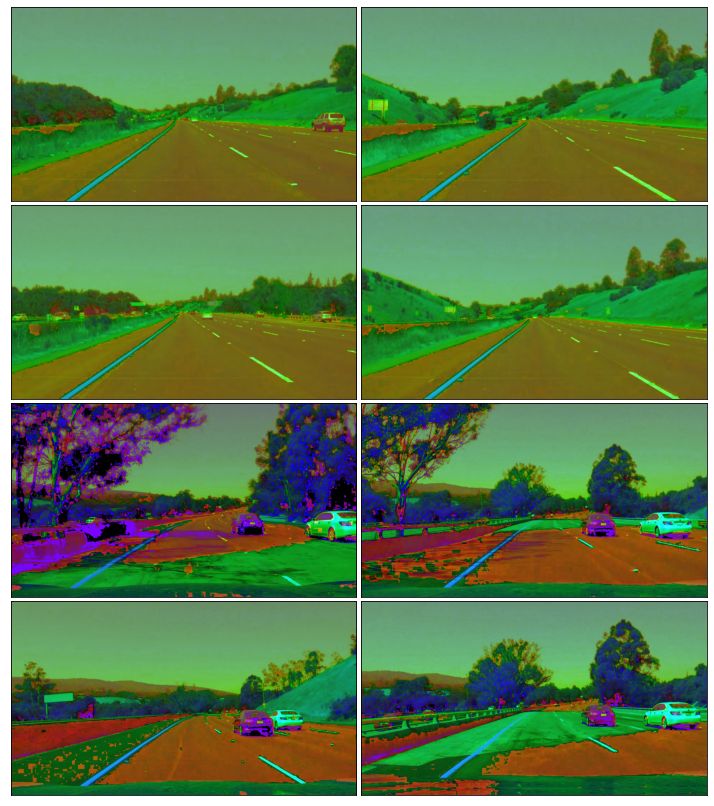

In [42]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

show_images(list(map(convert_hls, test_images)))

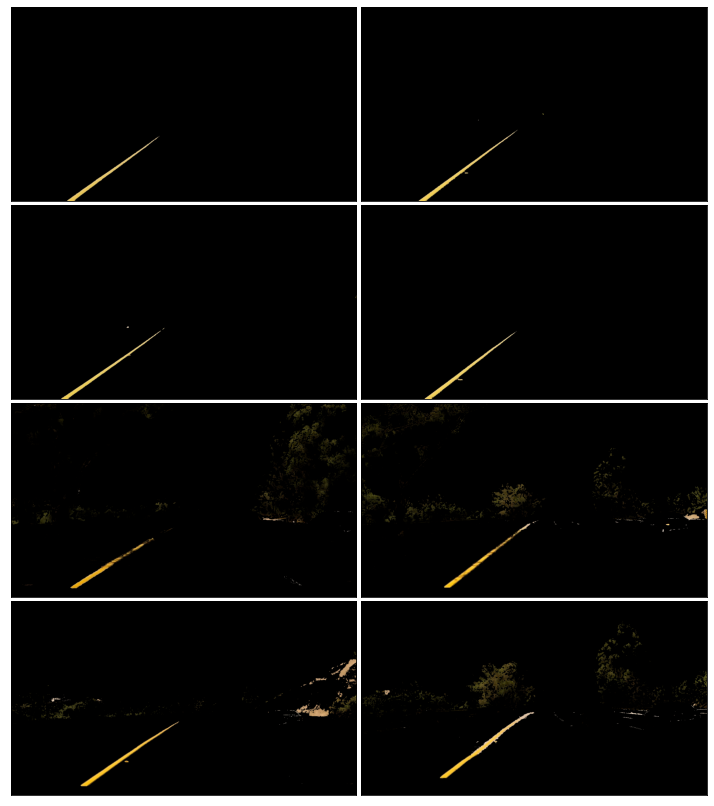

In [43]:
def select_yellow(image):
    converted = convert_hls(image)
   
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 30, 228, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    
    return cv2.bitwise_and(image, image, mask = yellow_mask)

yellow_images = list(map(select_yellow, test_images))

show_images(yellow_images)

## Gray Scaling

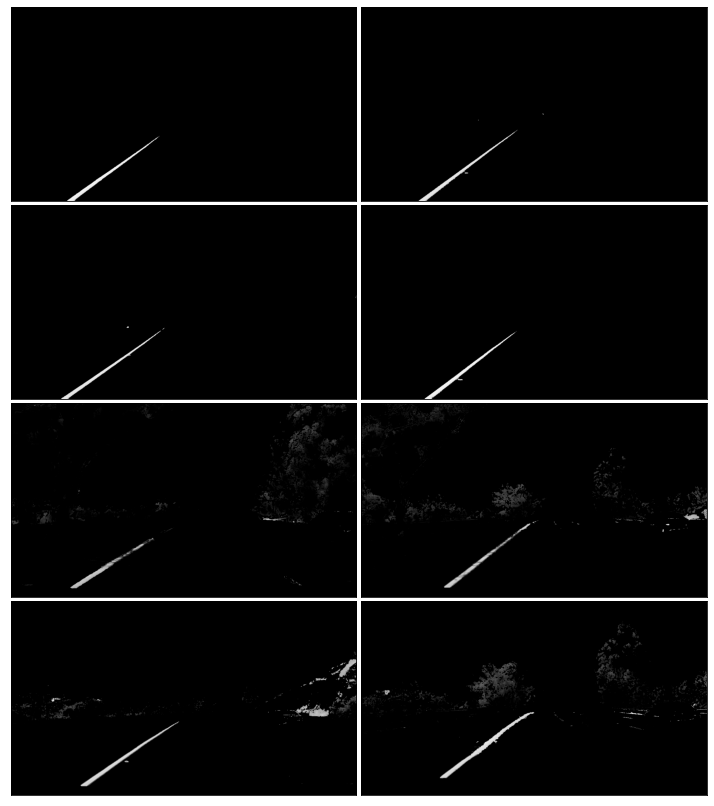

In [44]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, yellow_images))

show_images(gray_images)

## Gaussian Smoothing

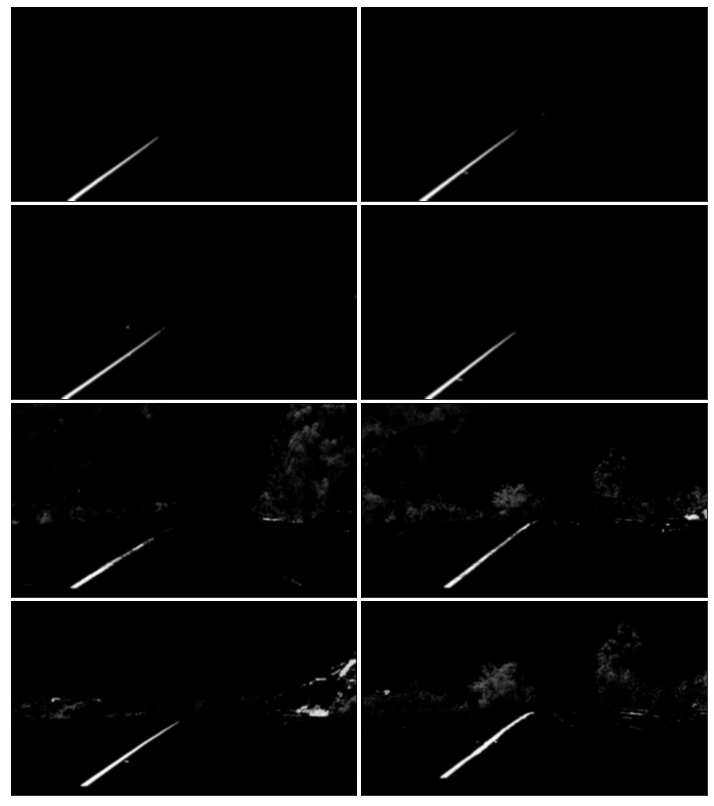

In [45]:
def apply_smoothing(image, kernel_size=15):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

show_images(blurred_images)

## Edge Detection

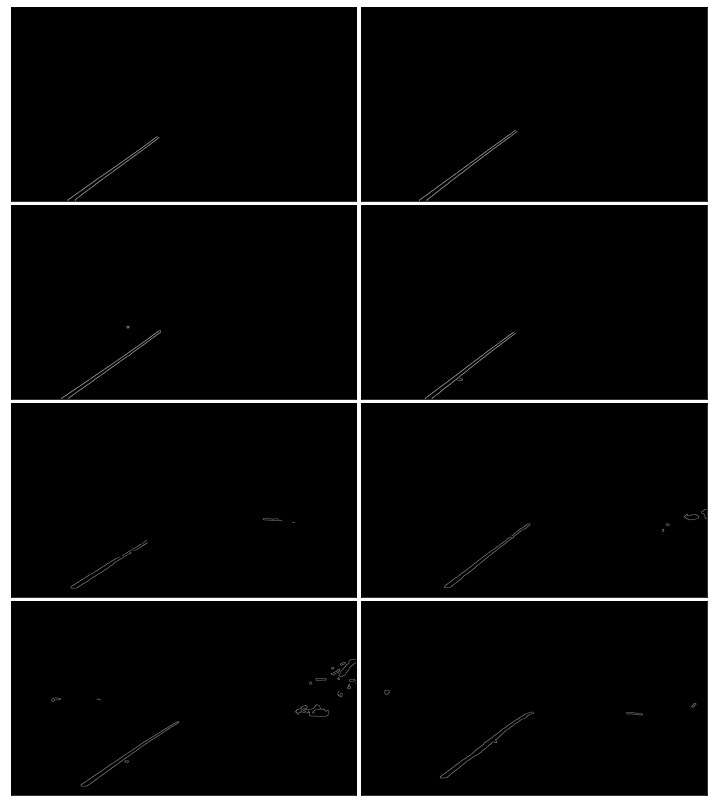

In [46]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))

show_images(edge_images)

## ROI Selection

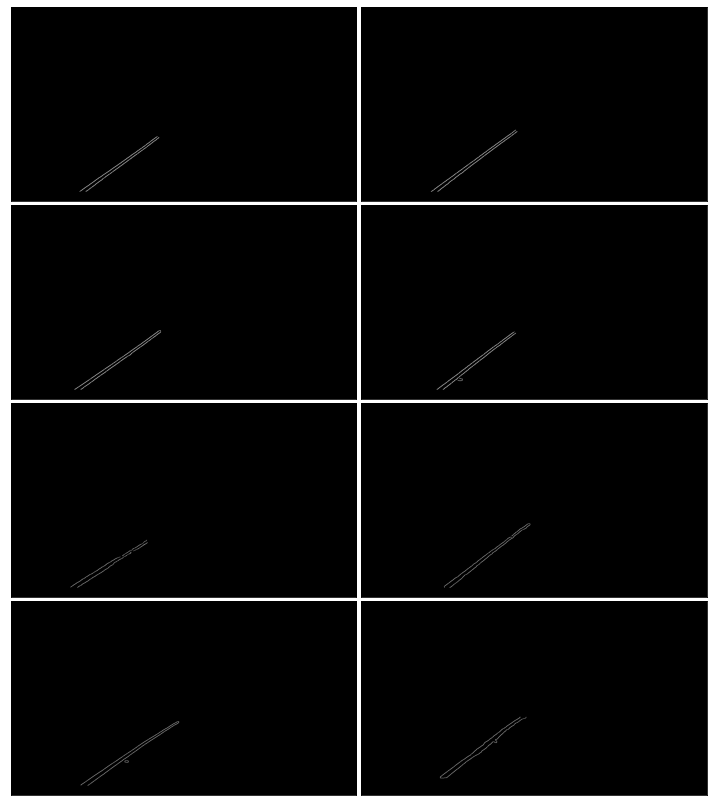

In [47]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)


# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

## Hough Transform

In [48]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=50, maxLineGap=300)


list_of_lines = list(map(hough_lines, roi_images))
print(list_of_lines)

[array([[[194, 510, 406, 361]],

       [[207, 513, 408, 366]],

       [[191, 513, 382, 379]],

       [[208, 513, 386, 383]]], dtype=int32), array([[[195, 513, 429, 343]],

       [[213, 512, 432, 347]],

       [[213, 513, 433, 347]],

       [[246, 486, 388, 379]]], dtype=int32), array([[[209, 492, 413, 350]],

       [[213, 500, 415, 354]],

       [[286, 448, 414, 355]],

       [[179, 512, 411, 350]],

       [[194, 513, 415, 353]],

       [[256, 460, 414, 350]]], dtype=int32), array([[[213, 512, 422, 355]],

       [[227, 513, 406, 373]],

       [[230, 512, 429, 357]],

       [[210, 513, 398, 372]],

       [[228, 513, 424, 354]]], dtype=int32), array([[[228, 677, 390, 576]],

       [[246, 684, 461, 545]],

       [[260, 676, 503, 519]],

       [[221, 682, 395, 574]],

       [[412, 567, 500, 512]],

       [[331, 631, 504, 519]],

       [[249, 681, 444, 554]],

       [[399, 573, 502, 509]],

       [[413, 567, 489, 520]],

       [[381, 593, 473, 540]]], dtype=int32), a

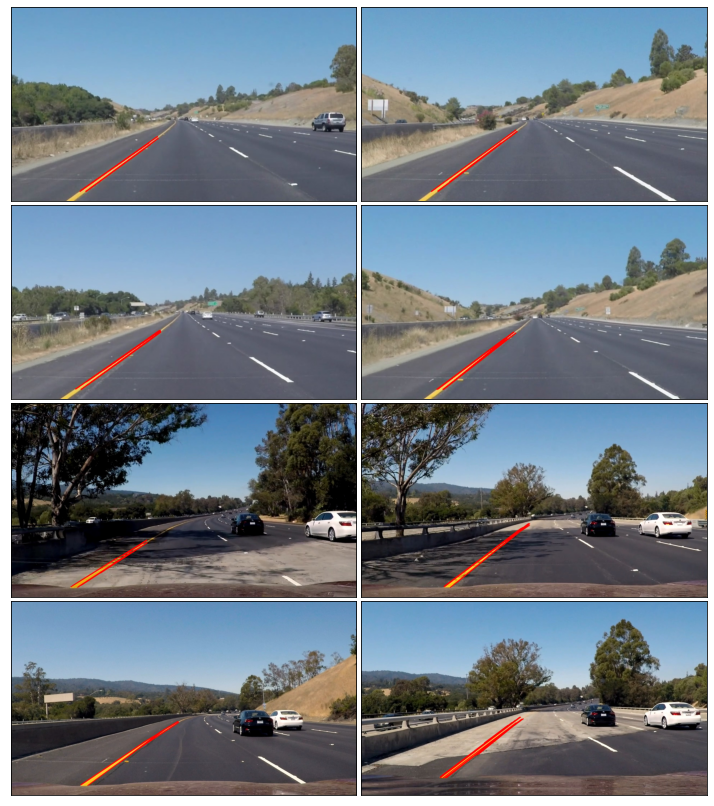

In [49]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

## Averaging and Extrapolating Lines

In [51]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
    
    # add more weight to longer lines    
    left_lane = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    
    return left_lane    # (slope, intercept), (slope, intercept)

In [52]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

In [53]:
def lane_lines(image, lines):
    left_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    
    return left_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
             
    
lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
show_images(lane_images)

error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt1'. Input argument doesn't provide sequence protocol
>  - Can't parse 'pt1'. Input argument doesn't provide sequence protocol
